In [1]:
# a setting for my cluster; ignore it
import os
os.environ['CUDA_MPS_PIPE_DIRECTORY'] = "/tmp/nvidia-mps"
os.environ['CUDA_MPS_LOG_DIRECTORY'] = "/tmp/nvidia-log"

In [2]:
import numpy as np
import pyDOE
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from scipy.optimize import rosen
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns

# NDCG estimator

In [3]:
def get_percentiles(arr):
    arr_sorted =  sorted(arr)
    # calculate percentiles using scipy func percentileofscore on each array element
    s = pd.Series(arr)
    return np.array(s.apply(lambda x: percentileofscore(arr_sorted, x)))

def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

# Data parameters (needed for NN architecture)

In [5]:
ndim = 10
def ans(x):
    return rosen(x.T)[:,None]

# NN arch

In [16]:
def iterate_minibatches(inputs, 
                        targets, 
                        batchsize, 
                        shuffle=True):
    """
    PRODUCES BATCHES
    """
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    if batchsize > len(inputs):
        yield inputs[indices], targets[indices]
    else:
        for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt]
        if len(inputs) % batchsize > 0:
            if shuffle:
                excerpt = indices[start_idx+batchsize:len(inputs)]
            else:
                excerpt = slice(start_idx+batchsize, len(inputs))
            yield inputs[excerpt], targets[excerpt]

In [17]:
layers = [512, 256, 256]
dat_mask_size = layers[1]

In [18]:
tf.reset_default_graph()
mask = tf.placeholder(tf.float32, [dat_mask_size])
input_data = tf.placeholder(tf.float32, 
                            [None, ndim])
answer = tf.placeholder(tf.float32, 
                        [None, 1])
l2_reg_ = tf.placeholder(tf.float32, 
                         name='l2reg')
# initializer = tf.contrib.layers.xavier_initializer()
initializer = tf.initializers.he_uniform()
activation = tf.nn.leaky_relu
W1 = tf.get_variable(
    name = f'W1',
    shape = (ndim, layers[0]),
    initializer = initializer)
b1 = tf.get_variable(
    name = f'b1',
    shape = (layers[0],),
    initializer = initializer)
h1 = activation(tf.matmul(
                    input_data, 
                    W1) + b1)
# ======================================
W2 = tf.get_variable(
    name = f'W2',
    shape = (layers[0], layers[1]),
    initializer = initializer)
b2 = tf.get_variable(
    name = f'b2',
    shape = (layers[1],),
    initializer = initializer)
h2 = activation(tf.matmul(h1, W2) + b2)
# =======================================
# hh2 = tf.boolean_mask(h2, mask, axis = 1)
hh2 = mask * h2
# =======================================
W3 = tf.get_variable(
    name = f'W3',
    shape = (layers[1], layers[2]),
    initializer = initializer)
b3 = tf.get_variable(
    name = f'b3',
    shape = (layers[2],),
    initializer = initializer)
h3 = activation(tf.matmul(hh2, W3) + b3)
# ======================================
# =======================================
W4 = tf.get_variable(
    name = f'W4',
    shape = (layers[2], 1),
    initializer = initializer)
b4 = tf.get_variable(
    name = f'b4',
    shape = (1,),
    initializer = initializer)
output = activation(tf.matmul(h3, W4) + b4)
# ======================================
# output = activation(tf.matmul(h, self.Ws[-1]) + self.bs[-1])
l2_regularizer = sum(tf.nn.l2_loss(Wxxx) for Wxxx in [W1, W2, W3, W4]) 
mse = tf.losses.mean_squared_error(predictions = output, 
                                   labels = answer)
loss = mse + l2_reg_*l2_regularizer
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).\
                        minimize(loss)

# masks stuff

In [19]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [20]:
def make_bmask(p = .5, n = dat_mask_size): # shitcode
    # here p is dropout probability
    res = np.ones((n,), dtype = float)
    if p > 0:
        perm = np.random.permutation(n)
        res[perm[:int(n*p)]] = 0.
    res *= 1./(1-p)
    return res

def generate_tree_masks(mask_size = 512, # deprecated
                        keep_probability = 0.5,
                        factor = 8,
                        shuffling = False
                       ):
    dropout_probability = 1 - keep_probability
    if factor > 16:
        raise Exception(f'The factor number ({factor}) is too large. Try 16, 8, 4')
    if int(factor*dropout_probability) != factor*dropout_probability:
        raise Exception(f'It is required for a factor*dropout_probability to be an integer')
    mask_length = int(mask_size * (1 - dropout_probability))
    nums = []
    for cnt in range(2**factor):
        if np.binary_repr(cnt, width=factor).count('0') == (factor*dropout_probability):
            nums.append(cnt)
    print(f'Total of {len(nums)} masks')
    data = []
    for cnt in range(len(nums)):
        num = nums[cnt]
        binary = np.binary_repr(num, width=factor)
        vec = ''.join(k*(mask_size // factor) for k in binary)
        numvec = np.array([False if k == '0' else True for k in vec])
        assert sum(numvec) <= mask_length
        if sum(numvec) != mask_length:
            diff = mask_length - sum(numvec)
            zero_inds = np.where(~numvec)[0]
            perm = np.random.permutation(range(mask_size))
            numvec[perm[:diff]] = True
        data.append(numvec)
    data = np.array(data, dtype = float)
    data *= 1./dropout_probability
    if shuffling:
        data = data[:, np.random.permutation(mask_size)]
    return data

def generate_circle_masks(keep_probability = 0.5,  # deprecated
                          mask_size = 512,
                          shuffling = False
                         ):
    dropout_probability = 1 - keep_probability
    current_mask = np.zeros((mask_size,), dtype = float)
    mask_length = int(mask_size * (1 - dropout_probability))
    current_mask[:(mask_length)] = 1.
    assert sum(current_mask) == mask_length
#     pointer = mask_length
    masks = [current_mask]
    for cnt in range(mask_size-1):
        current_mask = current_mask.copy()
        current_mask[(mask_length+cnt) % mask_size] = 1.
        current_mask[cnt] = 0.
#         print(cnt, (mask_length+cnt+1) % mask_size)
        if sum(current_mask) != mask_length:
            break
        masks.append(current_mask)
    masks = np.array(masks).astype(float)/dropout_probability
    if shuffling:
        masks = masks[:, np.random.permutation(mask_size)]
    return masks

def generate_lhs_masks(keep_probability = 0.5,  # nice
                       number_of_masks = None,
                       mask_size = 512,
                       shuffling = False):
    mt = pyDOE.lhs(n = mask_size,
                   samples = number_of_masks,
                  )
    mt = mt < keep_probability
    mt = mt.astype(float)/(1-keep_probability)
    if shuffling:
        mt = mt[:, np.random.permutation(mask_size)]
    return mt

def generate_random_masks(number_of_masks = 100,  # nice
                          mask_size = 512,
                          keep_probability = 0.5
                         ):
    dropout_probability = 1 - keep_probability
    masks = np.zeros((number_of_masks, mask_size), dtype = bool)
    mask_length = int(mask_size * (1 - dropout_probability))
    for cnt in range(number_of_masks):
        perm = np.random.permutation(range(mask_size))
        masks[cnt, perm[:mask_length]] = True
    masks = masks.astype(float)/dropout_probability
    return masks

def generate_random_mirror_masks(number_of_masks = 100,  # nice
                          mask_size = 512,
                          keep_probability = 0.5
                         ):
    if number_of_masks % 2:
        raise Exception('number_of_masks should be even')
    dropout_probability = 1 - keep_probability
    masks = np.zeros((number_of_masks, mask_size), dtype = bool)
    mask_length = int(mask_size * (1 - dropout_probability))
    for cnt in range(number_of_masks // 2):
        perm = np.random.permutation(range(mask_size))
        masks[2*cnt, perm[:mask_length]] = True
        masks[1 + 2*cnt, perm[mask_length:]] = True
    masks = masks.astype(float)/dropout_probability
    return masks

def generate_decorr_masks(abscorrs,  # nice
                          number_of_masks = 100,
                          mask_size = 512,
                          keep_probability = 0.5,
                          temperature = 1.
                         ):
    masks = []
    mask_length = int(mask_size * (keep_probability))
    for _ in range(number_of_masks):
        probs = softmax(1./abscorrs, 1./temperature)
        mask_ = np.zeros((mask_size,), dtype = bool)
        while sum(mask_) < mask_length:
            ind = np.random.choice(range(mask_size),
                                  p = probs)
            mask_[ind] = True
            probs[ind] = 0.
            probs *= 1./np.sum(probs)
        masks.append(mask_)
    masks = np.array(masks).astype(float)*1./(1.-keep_probability)
    return masks

def generate_alcorandom_masks(number_of_masks = 100,  # deprecated
                          mask_size = 512,
                         ):
    masks = np.zeros((number_of_masks, mask_size), dtype = float)
    for cnt in range(number_of_masks):
        dropout_probability = np.random.random()/2
        mask_length = int(mask_size * (1 - dropout_probability))
        perm = np.random.permutation(range(mask_size))
        masks[cnt, perm[:mask_length]] = 1./dropout_probability
    return masks

# training hyperp

In [21]:
epochs = 20000
p = .025
l2_reg = 1e-5
patience = 3
batch_size = 1000

verbose = 1
early_stopping = True
validation_window = 100

In [22]:
number_of_runs = 10

# data gathering

In [23]:
XX = np.random.random((13000, ndim))
yy = ans(XX)
dfw = pd.DataFrame(np.concatenate([XX, yy], axis = 1), 
                   columns = [f'q{w}' for w in range(1, 12)]
                  )

In [25]:
data = []
N_train, N_test, N_val = 2000, 10000, 1000

for run in range(number_of_runs):
    print('='*30)
    print(f'Run # {run}')
    print('='*30)
    
    dfk = dfw.sample(frac=1).reset_index(drop=1) 
    targets = dfk['q11']
    dfk = dfk.drop('q11', axis = 1)

    X_train = dfk.values[:N_train]
    y_train = targets.values[:N_train][:,None]

    X_test = dfk.values[N_train:(N_test+N_train)]
    y_test = targets.values[N_train:(N_test+N_train)][:,None]

    X_val = dfk.values[(N_test+N_train):]
    y_val = targets.values[(N_test+N_train):][:,None]
    
    print('shapes:', X_train.shape, y_train.shape)
    print('shapes:', X_test.shape, y_test.shape)
    
        # ==================================
    # init NN
    try:
        sess.close()
    except:
        pass
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session(config=config)
    sess.run(init)
    # ==================================
    # train
    previous_error = 1e+10
    current_patience = patience

    for epoch_num in range(1, 1 + epochs):
        for batch in iterate_minibatches(X_train, 
                                         y_train, 
                                         batch_size):
            X_batch, y_batch = batch
            sess.run(train_step,
                        feed_dict={input_data: X_batch, 
                                   answer: y_batch, 
                                   mask: make_bmask(p),
                                   l2_reg_: l2_reg})
        if (early_stopping) and \
            epoch_num % validation_window == 0:

            rmse_train = np.sqrt(
                sess.run(mse, 
                         feed_dict={input_data: X_train, 
                                    answer: y_train, 
                                    mask: make_bmask(p=0.)}))
            rmse_test = np.sqrt(
                sess.run(mse, 
                         feed_dict={input_data: X_test, 
                                    answer: y_test, 
                                    mask: make_bmask(p=0.)}))     
            rmse_val = np.sqrt(
                sess.run(mse, 
                         feed_dict={input_data: X_val, 
                                    answer: y_val, 
                                    mask: make_bmask(p=0.)})) 

            if rmse_val > previous_error:
                current_patience -= 1
            else:
                previous_error = rmse_val
                current_patience = patience
            if verbose:
                print(f'[{epoch_num}]'+\
                      f' RMSE train:{rmse_train:.3f}'+\
                      f' test:{rmse_test:.3f}'+\
                      f' val:{rmse_val:.3f}'+\
                      f' patience:{current_patience}')
            if current_patience <= 0:
                if verbose:
                    print(f'No patience left at epoch {epoch_num}.'+\
                    ' Early stopping.')
                break
    # ==================================
    # generate masks
    T = 128
    hk = sess.run(h2, feed_dict={input_data: X_val})
    corrs = np.corrcoef(hk.T)
    abscorrs = np.mean(np.abs(corrs), axis = 1)
    masks = {
        'lhs': generate_lhs_masks(mask_size = dat_mask_size,
                        number_of_masks = T),
        'lhs_shuffled': generate_lhs_masks(mask_size = dat_mask_size,
                        number_of_masks = T,
                        shuffling = True),
        'random': generate_random_masks(mask_size = dat_mask_size,
                    keep_probability = .5,
                    number_of_masks = T
                   ),
        'mirror_random': generate_random_mirror_masks(mask_size = dat_mask_size,
                    keep_probability = .5,
                    number_of_masks = T
                   ),
        'decorr': generate_decorr_masks(abscorrs, mask_size = dat_mask_size,
                    keep_probability = .5,
                    number_of_masks = T)
    }
    # UEs
    mask_types = list(masks.keys())
    
    mcd_realizations = []
    for mask_type in mask_types:
        current_mcd_realizations = np.zeros((T, X_test.shape[0]))
        for cnt in range(T):
            current_mcd_realizations[cnt,:] = np.ravel(sess.run(output,
                        feed_dict={input_data: X_test, 
                                   mask: masks[mask_type][cnt]}))
        mcd_realizations.append(current_mcd_realizations)
    # UE metrics prelude
    preds = sess.run(output,
                    feed_dict={input_data: X_test, 
                               mask: make_bmask(0.)})
    error = np.abs(np.ravel(preds)-np.ravel(y_test))
    worst_by_errorx = np.argsort(np.ravel(error))[::-1]
    error_perc = get_percentiles(error)
    error_digitized = np.digitize(error_perc, [80, 95, 99])
    # UE metrics
    for cnt, mask_type in enumerate(mask_types):
        mcdues = np.std(mcd_realizations[cnt], axis = 0)
        for perc in [.005, .01, .025, .05, .1]:
            k = int(X_test.shape[0]*perc)
            worst_by_error = worst_by_errorx[:k]
            worst_by_indicator = np.argsort(mcdues)[::-1][:k]
            accuracy = len(set(worst_by_error).\
                           intersection(set(worst_by_indicator)))/k
            ndcg = ndcg_at_k(error_digitized[np.argsort(mcdues)[::-1]], 
                              k = int(X_test.shape[0]*perc))
            data.append([run, mask_type, perc, accuracy, ndcg])
            print(f'ACC {mask_type}: {accuracy:.2f} @ {perc:.2f}%')
            print(f'NCDG {mask_type}: {ndcg:.2f} @ {perc:.2f}%')

Run # 0
shapes: (2000, 10) (2000, 1)
shapes: (10000, 10) (10000, 1)
[100] RMSE train:68.635 test:66.981 val:66.193 patience:3
[200] RMSE train:66.415 test:65.048 val:64.184 patience:3
[300] RMSE train:64.081 test:62.955 val:62.056 patience:3
[400] RMSE train:61.018 test:60.082 val:59.216 patience:3
[500] RMSE train:55.963 test:55.194 val:54.435 patience:3
[600] RMSE train:47.801 test:47.192 val:46.558 patience:3
[700] RMSE train:38.454 test:38.252 val:37.558 patience:3
[800] RMSE train:31.382 test:31.657 val:30.921 patience:3
[900] RMSE train:26.888 test:27.495 val:26.884 patience:3
[1000] RMSE train:23.841 test:24.280 val:23.348 patience:3
[1100] RMSE train:21.988 test:22.586 val:21.685 patience:3
[1200] RMSE train:20.795 test:21.621 val:20.864 patience:3
[1300] RMSE train:19.969 test:20.928 val:20.175 patience:3
[1400] RMSE train:19.355 test:20.436 val:19.712 patience:3
[1500] RMSE train:19.535 test:20.851 val:20.457 patience:2
[1600] RMSE train:18.506 test:19.848 val:19.165 patience

In [26]:
df = pd.DataFrame(data, columns = ['run',
                                   'mask',
                                   'perc',
                                   'acc',
                                   'ncdg'
                                  ])

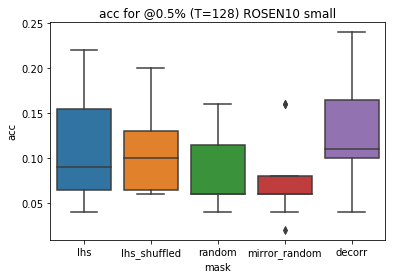

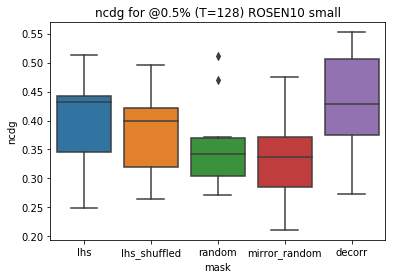

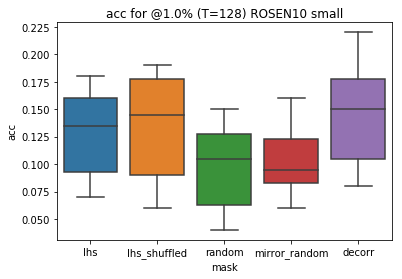

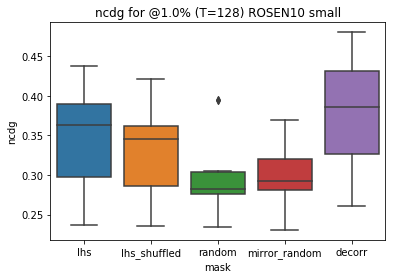

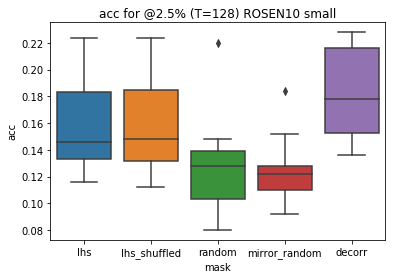

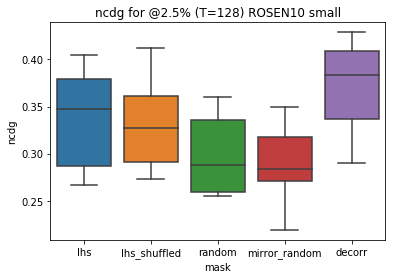

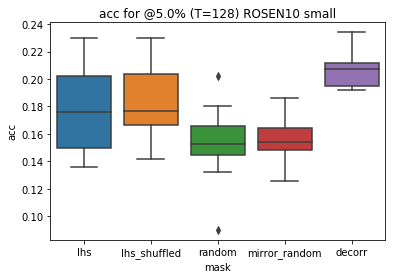

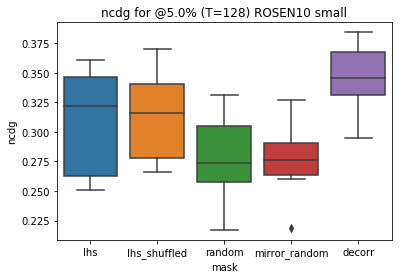

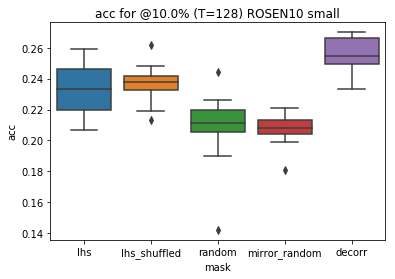

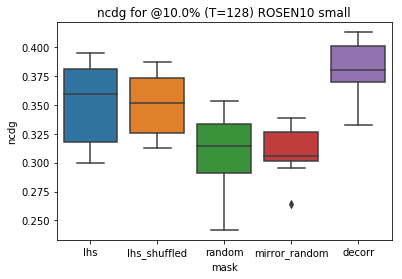

In [27]:
for perc in df.perc.unique():
    for yy in ['acc', 'ncdg']:
        plt.figure()
        sns.boxplot(data = df[(df.perc == perc)],
                    x = 'mask', y = yy)
        plt.title(f'{yy} for @{(100*perc):.1f}% (T={T}) ROSEN10 small')